In [1]:
import numpy as np 
import pandas as pd
import math as math
import random

import keras
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Model
import tensorflow as tf

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from triplet_encoding import generate_triplet, find_anchors
from shared_constants import IMAGE_DIR, ENCODING_COL

Using TensorFlow backend.


                               id encoding   anp cluster
                            count    count count   count
breed                                                   
basset                         65       65    65      65
bluetick                       68       68    68      68
collie                         69       69    69      69
german_short-haired_pointer    60       60    60      60
labrador_retriever             67       67    67      67
weimaraner                     68       68    68      68


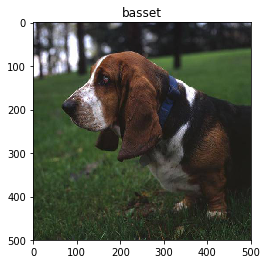

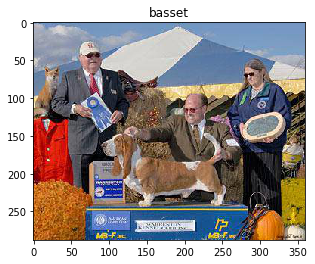

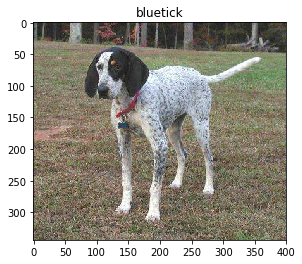

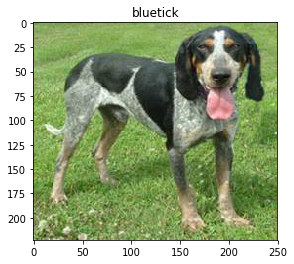

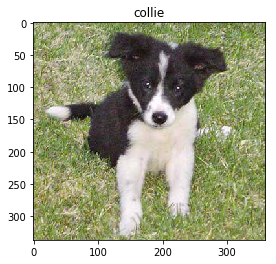

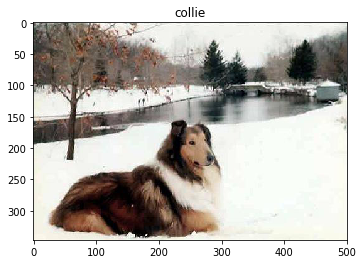

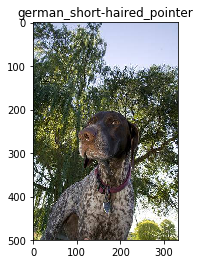

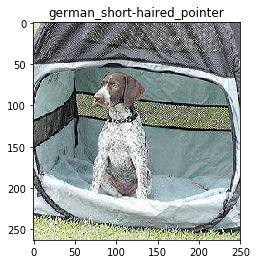

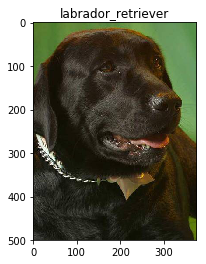

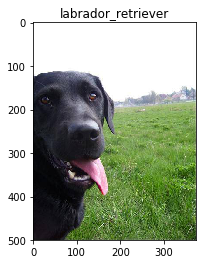

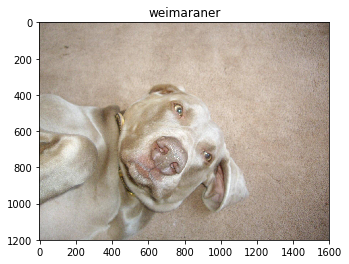

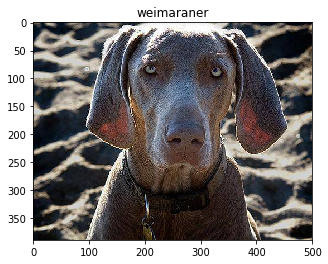

In [2]:
df_train_small = pd.read_csv("./input/labels_train_small_vgg19_4096_anchor.csv")

print(df_train_small.groupby(['breed']).agg(['count']))

breeds = df_train_small['breed'].unique()

for b in breeds:
    df_b = df_train_small[df_train_small['breed'] == b]
    for i in range(2):
        img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=df_b.iloc[i].id))
        plt.imshow(img)
        plt.title(b)
        plt.show()


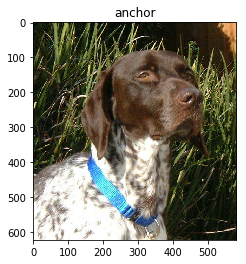

./input/train-2//244f5f60d9c5545d414295ace9a8c15b.jpg
german_short-haired_pointer


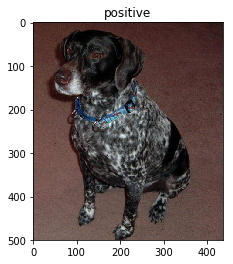

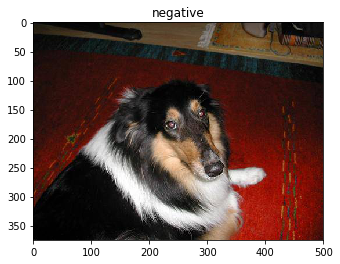

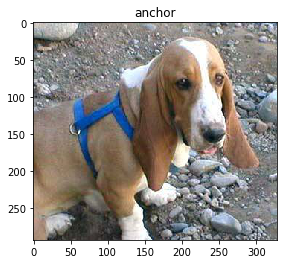

./input/train-2//b28dd4ec5ad70c3901a54447ef7ec5ab.jpg
basset


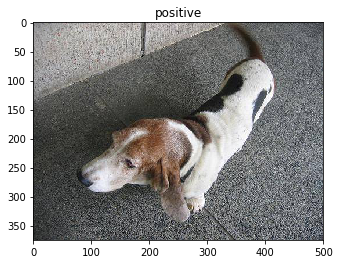

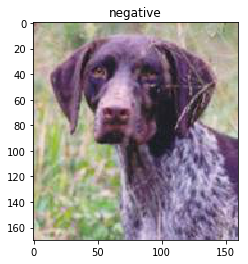

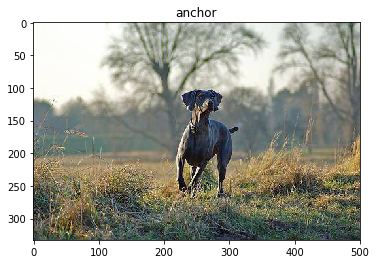

./input/train-2//a341328ad1bca600b3a8a0bb0cdde1bc.jpg
weimaraner


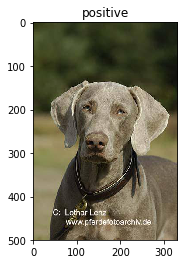

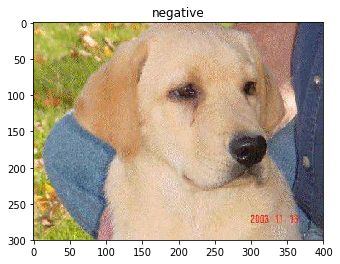

In [3]:
ENCODING_SIZE = 4096
N_ANCHORS = 12

def show_triplets(triplets):
    row = triplets[random.randint(0, len(triplets)-1)]
    anchor = row[0]
    anchor_path = IMAGE_DIR + '/{name}.jpg'.format(name=anchor['id'])
    img = Image.open(anchor_path)
    plt.imshow(img)
    plt.title('anchor')
    plt.show()
    print(anchor_path)
    print(anchor['breed'])
    img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=row[1]['id']))
    plt.imshow(img)
    plt.title('positive')
    plt.show()
    img = Image.open(IMAGE_DIR + '/{name}.jpg'.format(name=row[2]['id']))
    plt.imshow(img)
    plt.title('negative')
    plt.show()


triplets = generate_triplet(df_train_small, 'breed', N_ANCHORS)
np.random.shuffle(triplets)


random.seed()
show_triplets(triplets)
show_triplets(triplets)
show_triplets(triplets)



In [4]:
def load_triplets(triplets):
    n_triplets = len(triplets)
    anchors = np.zeros((n_triplets, 1, ENCODING_SIZE))
    pos = np.zeros((n_triplets, 1, ENCODING_SIZE))
    negs = np.zeros((n_triplets, 1, ENCODING_SIZE))

    i = 0
    for triplet in triplets:
        anchors[i] = np.loadtxt(triplet[0][ENCODING_COL])
        pos[i] = np.loadtxt(triplet[1][ENCODING_COL])
        negs[i] = np.loadtxt(triplet[2][ENCODING_COL])
        i = i + 1
        if (i % 1000 == 0):
            print('Loaded ' + str(i) + ' triplets')
    print('Loaded ' + str(n_triplets))
    
    return anchors, pos, negs

anchors, pos, negs = load_triplets(triplets)


Loaded 1000 triplets
Loaded 2000 triplets
Loaded 3000 triplets
Loaded 4000 triplets
Loaded 5000 triplets
Loaded 6000 triplets
Loaded 7000 triplets
Loaded 8000 triplets
Loaded 9000 triplets
Loaded 10000 triplets
Loaded 11000 triplets
Loaded 12000 triplets
Loaded 13000 triplets
Loaded 14000 triplets
Loaded 15000 triplets
Loaded 16000 triplets
Loaded 17000 triplets
Loaded 18000 triplets
Loaded 19000 triplets
Loaded 20000 triplets
Loaded 21000 triplets
Loaded 22000 triplets
Loaded 23000 triplets
Loaded 23820


In [5]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    basic_loss = tf.square(tf.add(alpha, tf.subtract(pos_dist, neg_dist)))
    loss = tf.reduce_sum(basic_loss)
    
    return loss

In [6]:
def input_encoding_model(encoded=(1, ENCODING_SIZE)):
    X_input = Input(encoded)

    X = Dense(4096, activation='sigmoid', name='fc0.0')(X_input)
    X = Dense(2056, activation='sigmoid', name='fc0.1')(X)
    X = Dense(1024, activation='sigmoid', name='fc1.0')(X)
    X = Dense(1024, activation='sigmoid', name='fc1.1')(X)
    X = Dense(512, activation='sigmoid', name='fc2')(X)
    X = Dense(128, activation='sigmoid', name='fc3.0')(X)
    X = Dense(128, activation='sigmoid', name='fc3.1')(X)

    model = Model(inputs=X_input, outputs=X, name='inputEncodingModel')
    
    return model
    

def input_training_model(a, p, n, encoding_model):
    X0_Input = Input(a)
    X1_Input = Input(p)
    X2_Input = Input(n)

    X0 = encoding_model(X0_Input)
    X1 = encoding_model(X1_Input)
    X2 = encoding_model(X2_Input)

    model = Model(inputs = [X0_Input, X1_Input, X2_Input], outputs = [X0, X1, X2], name = 'inputTrainingModel')
    
    return model

encoding_model = input_encoding_model()
training_model = input_training_model((1, ENCODING_SIZE), (1, ENCODING_SIZE), (1, ENCODING_SIZE), encoding_model)
training_model.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
training_model.optimizer.lr = 0.00000001


because we use the triplet loss function, we ignore the y_labels, hence we use y_dummies

In [8]:
# doggie_encoding_model.reset_states()
# doggie_breed_model.reset_states()

y_dummies = np.zeros((len(triplets), 1, len(triplets)))

training_model.fit(x=[anchors,pos,negs], y=[y_dummies,y_dummies,y_dummies] , batch_size=1024, epochs=1, shuffle=True)

Epoch 1/1
23820/23820 [==============================] - 220s 9ms/step - loss: 0.1200 - inputEncodingModel_loss_1: 0.0400 - inputEncodingModel_loss_2: 0.0400 - inputEncodingModel_loss_3: 0.0400 - inputEncodingModel_acc_1: 0.0000e+00 - inputEncodingModel_acc_2: 0.0000e+00 - inputEncodingModel_acc_3: 0.0000e+00


In [9]:
def model_encode(model, encoding_size):
    def encode(image_encoding):
        encoding = np.zeros((1,1, encoding_size))
        encoding[0] = image_encoding
        return model.predict_on_batch(encoding)
    return encode

def distance(encoding1, encoding2):
    return np.sum(np.square(np.subtract(encoding1, encoding2)), axis=-1)

def softmax(X):
    ps = np.exp(X)
    ps /= np.sum(ps)
    return ps

def get_class(result, identities):
    resulting_identity = identities.iloc[np.argmax(result)]
    return resulting_identity['breed']

identities = pd.DataFrame()
for breed in breeds:
    found_anchors = find_anchors(df_train_small, breed, 'breed', N_ANCHORS)
    identities = identities.append(found_anchors)

encoding_func = model_encode(encoding_model, ENCODING_SIZE)

identities_encoding = list(map(lambda x: np.loadtxt(x), identities[ENCODING_COL].values.tolist()))
identities_encoded = list(map(encoding_func, identities_encoding))
df_dev_small = pd.read_csv('./input/labels_dev_small_vgg19_4096.csv')

print(df_dev_small.shape)

prediction_error_count = 0
for i, row in df_dev_small.iterrows():
    row_encoding = encoding_func(np.loadtxt(row.encoding))
    result = []
    for id_encoding in identities_encoded:
        dist = distance(id_encoding, row_encoding)
        result.append(dist.item(0))
    result = 1 - np.array(result)
    result = softmax(result)
    predicted_breed = get_class(result, identities)
    if row['breed'] != predicted_breed:
        prediction_error_count += 1
        print('actual: {actual}, prediction: {prediction}'.format(actual=row['breed'], prediction=predicted_breed))
    
print('total prediction errors ' + str(prediction_error_count))

(101, 3)
actual: basset, prediction: bluetick
actual: basset, prediction: bluetick
actual: bluetick, prediction: basset
actual: bluetick, prediction: german_short-haired_pointer
actual: bluetick, prediction: german_short-haired_pointer
actual: bluetick, prediction: german_short-haired_pointer
actual: bluetick, prediction: collie
actual: collie, prediction: labrador_retriever
actual: german_short-haired_pointer, prediction: labrador_retriever
actual: german_short-haired_pointer, prediction: labrador_retriever
actual: german_short-haired_pointer, prediction: bluetick
actual: german_short-haired_pointer, prediction: weimaraner
actual: german_short-haired_pointer, prediction: bluetick
actual: labrador_retriever, prediction: german_short-haired_pointer
actual: labrador_retriever, prediction: german_short-haired_pointer
actual: labrador_retriever, prediction: weimaraner
actual: weimaraner, prediction: bluetick
actual: weimaraner, prediction: labrador_retriever
actual: weimaraner, prediction: